# ML Insights : Data Correlation Metrics

# Use Case

This Notebook shows how to configure following Data Correlation Metrics using ML Insights.

    PearsonCorrelation = Compute Pearson's Correlation metric for numerical-numerical features.
    CramersVCorrelation = Compute Cramer's V Correlation metric for categorical-categorical features.
    CorrelationRatio = Compute Correlation Ratio metric for categorical-numerical features.

## Note

- For Pearson's Correlation metric, it is required to specify Numerical feature types, as it is used for calculating correlation on Numerical-Numerical features. VariableType and DataType of feature to be specified:
    - variable_type=VariableType.CONTINUOUS or variable_type=VariableType.DISCRETE
    - Supported datatype: data_type=DataType.FLOAT or data_type=DataType.INTEGER
- For Cramer's V Correlation metric, it is required to specify Categorical feature types, as it is used for calculating correlation on Categorical-Categorical features. VariableType and DataType of feature to be specified:
    - variable_type=VariableType.NOMINAL, variable_type=VariableType.ORDINAL or variable_type=VariableType.BINARY
    - Supported datatype: data_type=DataType.FLOAT, data_type=DataType.INTEGER, data_type=DataType.STRING, data_type=DataType.TEXT, data_type=DataType.BOOLEAN
- For Correlation Ratio metric, it is required to specify Categorical and Numerical feature types, as it is used for calculating correlation on Categorical-Numerical features. VariableType and DataType of feature to be specified:
    - variable_type=VariableType.NOMINAL, variable_type=VariableType.ORDINAL, variable_type=VariableType.BINARY, VariableType.CONTINUOUS or variable_type=VariableType.DISCRETE
    - Supported datatype: data_type=DataType.FLOAT, data_type=DataType.INTEGER, data_type=DataType.STRING, data_type=DataType.TEXT, data_type=DataType.BOOLEAN    
- For all 3 metrics, FEATURE_LIST needs to be mandatorily specified in the config, where a minimum of 2 features need to be specified. This is because both correlation metrics need a minimum of 2 features to calculate correlation on.
 
## About Dataset
The data was collected and made available by “National Institute of Diabetes and Digestive and Kidney Diseases” as part of the Pima Indians Diabetes Database. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here belong to the Pima Indian heritage (subgroup of Native Americans), and are females of ages 21 and above.

The data set contains medical and demographic data of patients . It consists of various features such as Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, Outcome, Prediction, BMICategory, Prediction_Score .

Dataset source : https://www.kaggle.com/datasets/kandij/diabetes-dataset

**NOTE**: 4 more Categorical variables were added to the dataset for showcasing Cramer's V Correlation metric.


# Install ML Observability Insights Library SDK

- Prerequisites
    - Linux/Mac (Intel CPU)
    - Python 3.8 and 3.9 only


- Installation
    - ML Insights is made available as a Python package (via Artifactory) which can be installed using pip install as shown below. Depending on the execution engine on which to do the run, one can use scoped package. For eg: if we want to run on dask, use oracle-ml-insights[dask], for spark use oracle-ml-insights[spark], for native use oracle-ml-insights. One can install all the dependencies as use oracle-ml-insights[all]

      !pip install oracle-ml-insights

Refer : [Installation and Setup](https://docs.oracle.com/en-us/iaas/tools/ml-insights-docs/latest/ml-insights-documentation/html/user_guide/tutorials/install.html)

In [28]:
!python3 -m pip install oracle-ml-insights

Looking in indexes: https://artifactory.oci.oraclecorp.com/api/pypi/global-dev-pypi/simple
You should consider upgrading via the '/Users/kjindal/Intellij/mlm-insights/mlm-insights/bin/python3 -m pip install --upgrade pip' command.


In [29]:
!python3 -m pip install matplotlib

You should consider upgrading via the '/Users/kjindal/Intellij/mlm-insights/mlm-insights/bin/python3 -m pip install --upgrade pip' command.


# 1 ML Insights Imports

In [30]:
# imports

from mlm_insights.builder.builder_component import MetricDetail
from mlm_insights.builder.insights_builder import InsightsBuilder
from mlm_insights.constants.definitions import FEATURE_LIST
from mlm_insights.constants.types import FeatureType, DataType, VariableType
from mlm_insights.core.metrics.data_quality.cramers_v_correlation import CramersVCorrelation
from mlm_insights.core.metrics.data_quality.pearson_correlation import PearsonCorrelation
from mlm_insights.core.metrics.data_quality.correlation_ratio import CorrelationRatio
from mlm_insights.core.metrics.metric_metadata import MetricMetadata
from mlm_insights.mlm_native.readers import CSVNativeDataReader
import numpy as np
import matplotlib.pyplot as plt

# 2 Configure Feature schema

Feature Schema defines the structure and metadata of the input data, which includes data type, column type, column mapping.

In [31]:
def get_input_schema():
    return {
        "Pregnancies": FeatureType(data_type=DataType.INTEGER, variable_type=VariableType.CONTINUOUS),
        "Glucose": FeatureType(data_type=DataType.INTEGER, variable_type=VariableType.CONTINUOUS),
        "BloodPressure": FeatureType(data_type=DataType.INTEGER, variable_type=VariableType.CONTINUOUS),
        "SkinThickness": FeatureType(data_type=DataType.INTEGER, variable_type=VariableType.CONTINUOUS),
        "Insulin": FeatureType(data_type=DataType.INTEGER, variable_type=VariableType.CONTINUOUS),
        "BMI": FeatureType(data_type=DataType.FLOAT, variable_type=VariableType.CONTINUOUS),
        "DiabetesPedigreeFunction": FeatureType(data_type=DataType.FLOAT, variable_type=VariableType.CONTINUOUS),
        "Age": FeatureType(data_type=DataType.INTEGER, variable_type=VariableType.CONTINUOUS),
        "BMICategory": FeatureType(data_type=DataType.STRING, variable_type=VariableType.NOMINAL),
        "AgeCategory": FeatureType(data_type=DataType.STRING, variable_type=VariableType.NOMINAL),
        "PregnancyCategory": FeatureType(data_type=DataType.STRING, variable_type=VariableType.NOMINAL),
        "BPCategory": FeatureType(data_type=DataType.STRING, variable_type=VariableType.NOMINAL),
        "GlucoseCategory": FeatureType(data_type=DataType.STRING, variable_type=VariableType.NOMINAL)
    }


# 3 Configure Metrics

Here, we are going to configure both Correlation metrics.

In [32]:
def get_metrics():
    pearson_feature_list = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI",
        "DiabetesPedigreeFunction", "Age", "BMICategory"]

    cramers_v_feature_list = ["BMICategory", "AgeCategory", "PregnancyCategory", "BPCategory", "GlucoseCategory"]

    correlation_ratio_feature_list = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI",
        "DiabetesPedigreeFunction", "Age", "BMICategory", "BMICategory", "AgeCategory",
         "PregnancyCategory", "BPCategory", "GlucoseCategory"]

    correlation_metrics = [
        MetricMetadata(klass=PearsonCorrelation, config={FEATURE_LIST: pearson_feature_list}),
        MetricMetadata(klass=CramersVCorrelation, config={FEATURE_LIST: cramers_v_feature_list}),
        MetricMetadata(klass=CorrelationRatio, config={FEATURE_LIST: correlation_ratio_feature_list})
    ]
    metric_details = MetricDetail(univariate_metric={}, dataset_metrics=correlation_metrics)
    return metric_details

# 4 Configure Data Reader

We will configure the Data Reader to read our data set by directly giving the location of the data set.

In [33]:
def get_reader():
    csv_reader = CSVNativeDataReader("input_data/diabetes_dataset2.csv")
    return csv_reader

# 5 Compute the Profile 

Create the builder object, get the runner, use run() to run the workflow and get the resulting profile.

In [34]:
def main():
    # Set up the insights builder by passing: input schema, metric, data frame and engine details
    runner = InsightsBuilder(). \
        with_input_schema(get_input_schema()). \
        with_metrics(metrics=get_metrics()). \
        with_reader(reader=get_reader()). \
        build()

    # Run the evaluation
    run_result = runner.run()
    return run_result.profile

profile = main()
profile_json = profile.to_json()

# 6 Profile Result

## 6.1.1 Print Pearson's Correlation Matrix as 2-D array

In [35]:
pearson_value = profile_json["dataset_metrics"]["PearsonCorrelation"]["metric_data"]

result_feature_list = pearson_value[0]
pearsons_correlation_matrix = pearson_value[1]


np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

print(pearsons_correlation_matrix)


[[1.0, 0.008783662934226753, 0.22642189492514853, 0.008024709356665178, 0.20699380831734146, -0.13544088378902538, 0.5565164729534167, -0.0914600432901296], [0.008783662934226753, 1.0, 0.25766475847017245, 0.11792866548665994, 0.1938783185022642, 0.18955007486863582, 0.004168364137108492, 0.4179839789240739], [0.22642189492514853, 0.25766475847017245, 1.0, 0.06452189030290699, 0.14830542198416605, 0.09984183668910648, 0.18042435957652242, 0.24994455029813592], [0.008024709356665178, 0.11792866548665994, 0.06452189030290699, 1.0, 0.08937032495625073, 0.17739704122706693, -0.03973250860541743, 0.1989009773413284], [0.20699380831734146, 0.1938783185022642, 0.14830542198416605, 0.08937032495625073, 1.0, 0.2929489284976619, 0.08793791717755166, 0.06447000205157481], [-0.13544088378902538, 0.18955007486863582, 0.09984183668910648, 0.17739704122706693, 0.2929489284976619, 1.0, -0.14211548151236533, 0.4332131885542025], [0.5565164729534167, 0.004168364137108492, 0.18042435957652242, -0.0397325

## 6.1.2 Visualize the Pearson's Correlation Matrix

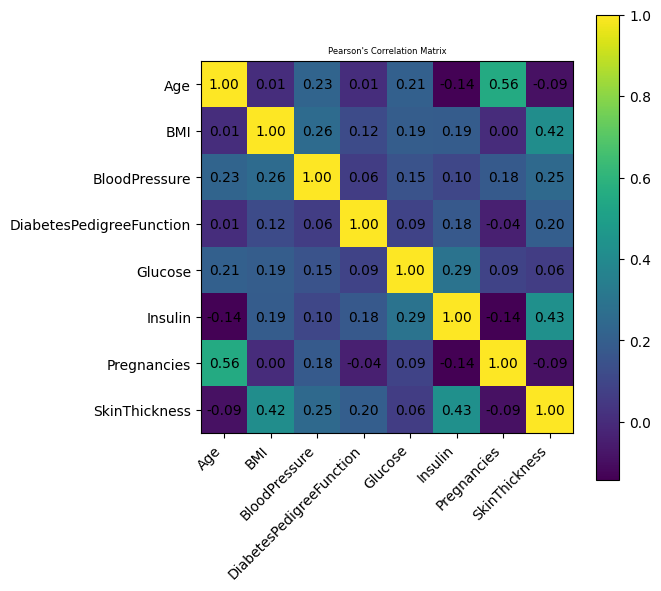

In [36]:
f = plt.figure(figsize=(6, 6))
plt.matshow(pearsons_correlation_matrix, fignum=f.number)
plt.title('Pearson\'s Correlation Matrix', fontsize=6);
plt.xticks(range(0,len(result_feature_list)), result_feature_list, rotation=45, ha = "right")
plt.yticks(range(0,len(result_feature_list)), result_feature_list)
cb = plt.colorbar()

ax = plt.gca()
ax.tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)

for (x, y), value in np.ndenumerate(pearsons_correlation_matrix):
    plt.text(x, y, f"{value:.2f}", va="center", ha="center")

plt.show()

## 6.2.1 Print Cramer's V Correlation Matrix as 2-D array

In [37]:
cramer_value = profile_json["dataset_metrics"]["CramersVCorrelation"]["metric_data"]

result_feature_list = cramer_value[0]
cramers_correlation_matrix = cramer_value[1]

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

print(cramers_correlation_matrix)

[[1.0, 0.13162330472619269, 0.19166036839601125, 0.18606154340095593, 0.5677929459392335], [0.13162330472619269, 1.0, 0.15711485527646865, 0.13174784607981446, 0.050299303553575814], [0.19166036839601125, 0.15711485527646865, 0.9999999999999999, 0.165204323184368, 0.20987691071957246], [0.18606154340095593, 0.13174784607981446, 0.165204323184368, 1.0, 0.0910393085498858], [0.5677929459392335, 0.050299303553575814, 0.20987691071957246, 0.0910393085498858, 0.9999999999999999]]


## 6.2.2 Visualize the Cramer's V Correlation Matrix

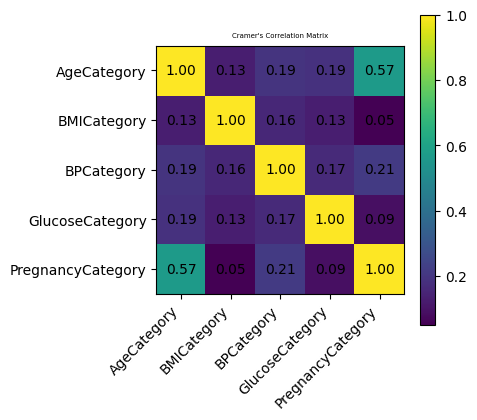

In [38]:
f = plt.figure(figsize=(4, 4))
plt.matshow(cramers_correlation_matrix, fignum=f.number)
plt.title('Cramer\'s Correlation Matrix', fontsize=5);
plt.xticks(range(0,len(result_feature_list)), result_feature_list, rotation=45, ha = "right")
plt.yticks(range(0,len(result_feature_list)), result_feature_list)
cb = plt.colorbar()

ax = plt.gca()
ax.tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)

for (x, y), value in np.ndenumerate(cramers_correlation_matrix):
    plt.text(x, y, f"{value:.2f}", va="center", ha="center")

plt.show()

## 6.3.1 Print Correlation Ratio Matrix as 2-D array

In [39]:
correlation_ratio_value = profile_json["dataset_metrics"]["CorrelationRatio"]["metric_data"]

correlation_ratio_matrix = correlation_ratio_value[0]
correlation_ratio_categorical_features = correlation_ratio_value[1]
correlation_ratio_numerical_features = correlation_ratio_value[2]

np.set_printoptions(precision=5)
np.set_printoptions(suppress=True)

print(correlation_ratio_matrix, correlation_ratio_categorical_features, correlation_ratio_numerical_features)

[[0.9179479650108285, 0.14215949875052, 0.22495410525837084, 0.013428671335615209, 0.18467275904565922, 0.14355690109090016, 0.5715697922164081, 0.07904715030601468], [0.0664768782526509, 0.8211277496860816, 0.2798734605605394, 0.07037872867460392, 0.17008419467932612, 0.19245810379278078, 0.06483198166548347, 0.38483905992517903], [0.27481817952495696, 0.2345876507203818, 0.8135686179137472, 0.04056743850426341, 0.18097387995937167, 0.059379550289361, 0.20935617775268006, 0.1624316916597244], [0.2461821464697876, 0.17170790367605165, 0.17353014667637848, 0.07137720873704677, 0.8341703657145799, 0.2770962415588786, 0.10610386515012771, 0.05708153088765935], [0.5712707731482549, 0.0006789980213550179, 0.18453095117240303, 0.03623940717681654, 0.09130113072950623, 0.1275471357734521, 0.8656989136212995, 0.08514179906048135]] ['AgeCategory', 'BMICategory', 'BPCategory', 'GlucoseCategory', 'PregnancyCategory'] ['Age', 'BMI', 'BloodPressure', 'DiabetesPedigreeFunction', 'Glucose', 'Insulin'

## 6.3.2 Visualize the Correlation Ratio Matrix

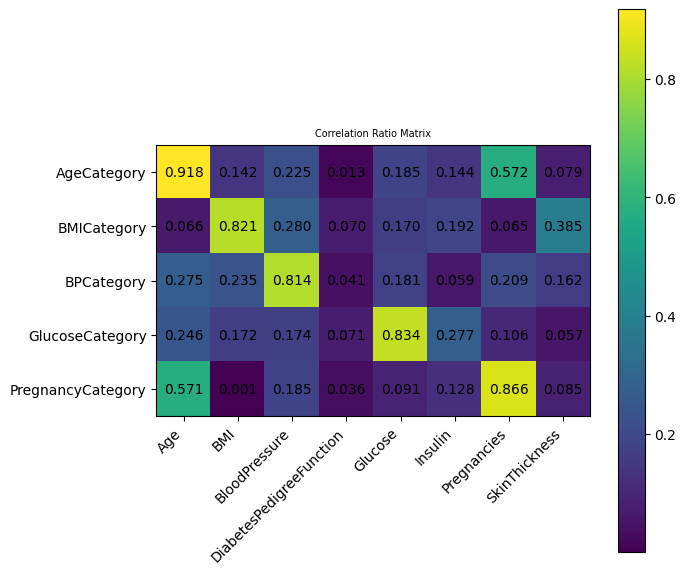

In [40]:
f = plt.figure(figsize=(7, 7))
plt.matshow(correlation_ratio_matrix, fignum=f.number)
plt.title('Correlation Ratio Matrix', fontsize=7);
plt.xticks(range(0, len(correlation_ratio_numerical_features)), correlation_ratio_numerical_features, rotation=45, ha = "right")
plt.yticks(range(0, len(correlation_ratio_categorical_features)), correlation_ratio_categorical_features)
cb = plt.colorbar()

ax = plt.gca()
ax.tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)

for (x, y), value in np.ndenumerate(correlation_ratio_matrix):
    plt.text(y, x, f"{value:.3f}", va="center", ha="center")

plt.show()